In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))


Using: cuda
NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
DATA_DIR   = r"C:\Users\richu\Data\ChestXray14"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
CSV_MAIN   = os.path.join(DATA_DIR, "Data_Entry_2017_v2020.csv")

IMG_SIZE       = 1024
USE_FRACTION   = 1.00      # ← CHANGE THIS to 0.25 or 1.0 later
BATCH_SIZE     = 1         # 1024x1024 is huge
NUM_WORKERS    = 0

LATENT_DIM     = 64
VAE_LR         = 1e-4
VAE_EPOCHS     = 10
BETA_KL        = 1e-3      # stronger KL

CLS_HIDDEN_DIM = 256
CLS_LR         = 1e-3
CLS_EPOCHS     = 20


In [3]:
df = pd.read_csv(CSV_MAIN)

df = df.rename(columns={
    "Image Index": "Image",
    "Finding Labels": "Finding_Labels"
})
df["path"] = df["Image"].apply(lambda x: os.path.join(IMAGES_DIR, x))
df = df[df["path"].apply(os.path.isfile)].reset_index(drop=True)

def any_abnormal(labels):
    return 0 if labels == "No Finding" else 1

df["any_abnormal"] = df["Finding_Labels"].apply(any_abnormal)

# --- APPLY FRACTION ---
if USE_FRACTION < 1.0:
    df_small, _ = train_test_split(
        df,
        test_size=1.0 - USE_FRACTION,
        stratify=df["any_abnormal"],
        random_state=SEED,
    )
else:
    df_small = df.copy()

print(f"Using {len(df_small)} images out of {len(df)}  ({USE_FRACTION*100:.0f}%)")


Using 112120 images out of 112120  (100%)


In [4]:
train_df, temp_df = train_test_split(
    df_small,
    test_size=0.30,
    stratify=df_small["any_abnormal"],
    random_state=SEED,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["any_abnormal"],
    random_state=SEED,
)

print("Train size:", len(train_df))
print("Val size  :", len(val_df))
print("Test size :", len(test_df))


Train size: 78484
Val size  : 16818
Test size : 16818


In [5]:
def labels_to_multihot(labels_str, disease_to_idx):
    y = np.zeros(len(disease_to_idx), dtype=np.float32)
    for lab in labels_str.split("|"):
        lab = lab.strip()
        if lab == "No Finding" or lab == "":
            continue
        if lab in disease_to_idx:
            y[disease_to_idx[lab]] = 1.0
    return y

# build disease list
all_labels = set()
for s in df["Finding_Labels"]:
    for lab in s.split("|"):
        lab = lab.strip()
        if lab != "No Finding" and lab != "":
            all_labels.add(lab)

disease_names = sorted(all_labels)
disease_to_idx = {d:i for i,d in enumerate(disease_names)}
num_classes = len(disease_names)

print("Diseases:", disease_names)


Diseases: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
full_transform = T.Compose([
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

class FullImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row["path"]).convert("L")
        x = self.transform(img)
        y = labels_to_multihot(row["Finding_Labels"], disease_to_idx)
        return x, torch.tensor(y, dtype=torch.float32), row["path"]

train_ds = FullImageDataset(train_df, full_transform)
val_ds   = FullImageDataset(val_df, full_transform)
test_ds  = FullImageDataset(test_df, full_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


In [7]:
class FullImageVAE_NoSkip1024(nn.Module):
    def __init__(self, z_dim=LATENT_DIM):
        super().__init__()
        self.z_dim = z_dim

        # ----- Encoder -----
        self.enc1 = nn.Sequential(nn.Conv2d(1,16,4,2,1), nn.LeakyReLU(0.2))
        self.enc2 = nn.Sequential(nn.Conv2d(16,32,4,2,1), nn.LeakyReLU(0.2))
        self.enc3 = nn.Sequential(nn.Conv2d(32,64,4,2,1), nn.LeakyReLU(0.2))
        self.enc4 = nn.Sequential(nn.Conv2d(64,128,4,2,1), nn.LeakyReLU(0.2))
        self.enc5 = nn.Sequential(nn.Conv2d(128,256,4,2,1), nn.LeakyReLU(0.2))
        self.enc6 = nn.Sequential(nn.Conv2d(256,256,4,2,1), nn.LeakyReLU(0.2))  # → 16×16

        self.spatial = 16
        flat_dim = 256*16*16

        self.fc_mu     = nn.Linear(flat_dim, z_dim)
        self.fc_logvar = nn.Linear(flat_dim, z_dim)

        self.fc_dec = nn.Linear(z_dim, flat_dim)

        # ----- Decoder -----
        self.dec6 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.LeakyReLU(0.2))
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1), nn.LeakyReLU(0.2))
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1), nn.LeakyReLU(0.2))
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(64,32,4,2,1), nn.LeakyReLU(0.2))
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(32,16,4,2,1), nn.LeakyReLU(0.2))
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(16,1,4,2,1), nn.Sigmoid())

    def encode(self, x):
        h = self.enc1(x)
        h = self.enc2(h)
        h = self.enc3(h)
        h = self.enc4(h)
        h = self.enc5(h)
        h = self.enc6(h)
        flat = h.view(h.size(0), -1)
        mu = self.fc_mu(flat)
        logvar = torch.clamp(self.fc_logvar(flat), -10, 10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.fc_dec(z).view(-1,256,self.spatial,self.spatial)
        h = self.dec6(h)
        h = self.dec5(h)
        h = self.dec4(h)
        h = self.dec3(h)
        h = self.dec2(h)
        x_hat = self.dec1(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu,logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [8]:
vae = FullImageVAE_NoSkip1024().to(device)
opt = torch.optim.Adam(vae.parameters(), lr=VAE_LR)


In [9]:
def vae_loss(x, x_hat, mu, logvar, beta=BETA_KL):
    rec = F.l1_loss(x_hat, x, reduction="mean")
    kl  = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return rec + beta*kl, rec, kl

for epoch in range(1, VAE_EPOCHS + 1):
    vae.train()
    tot_loss = tot_rec = tot_kl = 0.0
    batches = 0

    # ---- start timer for this epoch ----
    epoch_start = time.time()

    total_steps = len(train_loader)
    step = 0

    for x, _, _ in train_loader:
        step += 1
        batch_start = time.time()

        x = x.to(device)
        opt.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss, rec, kl = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        opt.step()

        tot_loss += loss.item()
        tot_rec  += rec.item()
        tot_kl   += kl.item()
        batches  += 1

        # ---- compute ETA for remaining steps in this epoch ----
        batch_time = time.time() - batch_start
        remaining_steps = total_steps - step
        eta_seconds = remaining_steps * batch_time

        # live ETA line (overwrites itself)
        print(
            f"Epoch {epoch}/{VAE_EPOCHS} | "
            f"step {step}/{total_steps} | "
            f"batch_time={batch_time:.2f}s | "
            f"ETA={eta_seconds/60:.1f} min   ",
            end="\r"
        )

    # ---- epoch finished ----
    epoch_time = time.time() - epoch_start

    avg_loss = tot_loss / batches
    avg_rec  = tot_rec  / batches
    avg_kl   = tot_kl   / batches

    # final clean print for the epoch
    print()  # move to new line after the \r printing
    print(
        f"Epoch {epoch}/{VAE_EPOCHS} | "
        f"loss {avg_loss:.4f} | rec {avg_rec:.4f} | kl {avg_kl:.4f} | "
        f"time {epoch_time:.2f}s ({epoch_time/60:.2f} min)"
    )


Epoch 1/10 | step 78484/78484 | batch_time=0.01s | ETA=0.0 min    
Epoch 1/10 | loss 0.0433 | rec 0.0405 | kl 2.8113 | time 3046.58s (50.78 min)
Epoch 2/10 | step 78484/78484 | batch_time=0.03s | ETA=0.0 min    
Epoch 2/10 | loss 0.0355 | rec 0.0327 | kl 2.8380 | time 3010.92s (50.18 min)
Epoch 3/10 | step 78484/78484 | batch_time=0.02s | ETA=0.0 min    
Epoch 3/10 | loss 0.0341 | rec 0.0313 | kl 2.8209 | time 3004.84s (50.08 min)
Epoch 4/10 | step 78484/78484 | batch_time=0.02s | ETA=0.0 min    
Epoch 4/10 | loss 0.0334 | rec 0.0305 | kl 2.8085 | time 3010.27s (50.17 min)
Epoch 5/10 | step 78484/78484 | batch_time=0.03s | ETA=0.0 min    
Epoch 5/10 | loss 0.0328 | rec 0.0300 | kl 2.7983 | time 3004.51s (50.08 min)
Epoch 6/10 | step 78484/78484 | batch_time=0.02s | ETA=0.0 min    
Epoch 6/10 | loss 0.0324 | rec 0.0296 | kl 2.7896 | time 3003.79s (50.06 min)
Epoch 7/10 | step 78484/78484 | batch_time=0.02s | ETA=0.0 min    
Epoch 7/10 | loss 0.0321 | rec 0.0293 | kl 2.7833 | time 3005.4

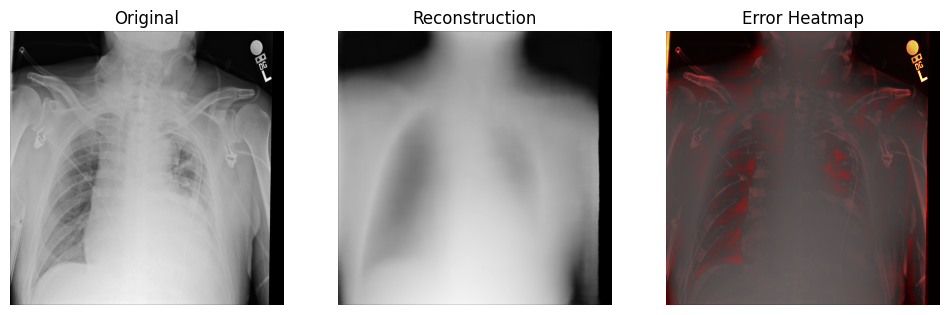

In [10]:
vae.eval()
x, y, path = next(iter(val_loader))
x = x.to(device)

with torch.no_grad():
    x_hat, mu, logvar = vae(x)

orig = x.cpu().numpy()[0,0]
recon = x_hat.cpu().numpy()[0,0]

err = np.abs(orig - recon)
err_norm = err / (err.max() + 1e-8)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(orig, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(recon, cmap='gray'); plt.title("Reconstruction"); plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(orig, cmap='gray')
plt.imshow(err_norm, cmap='hot', alpha=0.6)
plt.title("Error Heatmap")
plt.axis("off")
plt.show()


In [11]:
@torch.no_grad()
def extract_latents(dataset, model):
        model.eval()
        X = []
        Y = []
    
        loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
        for x, y, _ in loader:
            x = x.to(device)
            mu, logvar = model.encode(x)
            X.append(mu.cpu().numpy()[0])
            Y.append(y.numpy()[0])
    
        return np.vstack(X), np.vstack(Y)
    
train_X, train_Y = extract_latents(train_ds, vae)
val_X,   val_Y   = extract_latents(val_ds, vae)
test_X,  test_Y  = extract_latents(test_ds, vae)
    
print(train_X.shape, train_Y.shape)


(78484, 64) (78484, 14)


In [12]:
class LatentMLP(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hidden=CLS_HIDDEN_DIM, num_classes=num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes),
        )
    def forward(self, z):
        return self.net(z)

cls = LatentMLP().to(device)
cls_opt = torch.optim.Adam(cls.parameters(), lr=CLS_LR)
criterion = nn.BCEWithLogitsLoss()


In [13]:
CLS_HIDDEN_DIM = 256
CLS_LR         = 1e-3
CLS_EPOCHS     = 20
CLS_BATCH_SIZE = 64   # <--- ADD THIS LINE


In [14]:
def train_cls_epoch(X, Y):
    cls.train()
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]

    BS = CLS_BATCH_SIZE
    total_loss = 0
    for i in range(0, len(X), BS):
        xb = torch.tensor(X[i:i+BS], dtype=torch.float32, device=device)
        yb = torch.tensor(Y[i:i+BS], dtype=torch.float32, device=device)

        cls_opt.zero_grad()
        logits = cls(xb)
        loss = criterion(logits, yb)
        loss.backward()
        cls_opt.step()
        total_loss += loss.item()
    return total_loss / max(1, (len(X)//BS))

def eval_cls(X, Y):
    cls.eval()
    with torch.no_grad():
        xb = torch.tensor(X, dtype=torch.float32, device=device)
        logits = cls(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
    return preds

for epoch in range(1, CLS_EPOCHS+1):
    loss = train_cls_epoch(train_X, train_Y)
    preds = eval_cls(val_X, val_Y)
    f1 = classification_report(val_Y, preds, target_names=disease_names, zero_division=0, output_dict=True)["macro avg"]["f1-score"]
    print(f"Epoch {epoch}/{CLS_EPOCHS}: loss={loss:.4f}, macro-F1={f1:.4f}")


Epoch 1/20: loss=0.1774, macro-F1=0.0019
Epoch 2/20: loss=0.1676, macro-F1=0.0194
Epoch 3/20: loss=0.1646, macro-F1=0.0202
Epoch 4/20: loss=0.1624, macro-F1=0.0316
Epoch 5/20: loss=0.1603, macro-F1=0.0366
Epoch 6/20: loss=0.1584, macro-F1=0.0302
Epoch 7/20: loss=0.1566, macro-F1=0.0388
Epoch 8/20: loss=0.1546, macro-F1=0.0449
Epoch 9/20: loss=0.1526, macro-F1=0.0375
Epoch 10/20: loss=0.1507, macro-F1=0.0443
Epoch 11/20: loss=0.1488, macro-F1=0.0504
Epoch 12/20: loss=0.1466, macro-F1=0.0660
Epoch 13/20: loss=0.1446, macro-F1=0.0596
Epoch 14/20: loss=0.1425, macro-F1=0.0573
Epoch 15/20: loss=0.1405, macro-F1=0.0687
Epoch 16/20: loss=0.1385, macro-F1=0.0665
Epoch 17/20: loss=0.1365, macro-F1=0.0754
Epoch 18/20: loss=0.1346, macro-F1=0.0748
Epoch 19/20: loss=0.1329, macro-F1=0.0751
Epoch 20/20: loss=0.1311, macro-F1=0.0759


In [15]:
test_preds = eval_cls(test_X, test_Y)
print("TEST RESULTS:")
print(classification_report(test_Y, test_preds, target_names=disease_names, digits=4, zero_division=0))


TEST RESULTS:
                    precision    recall  f1-score   support

       Atelectasis     0.3193    0.0882    0.1382      1724
      Cardiomegaly     0.3265    0.0742    0.1210       431
     Consolidation     0.1346    0.0103    0.0191       682
             Edema     0.1846    0.0314    0.0537       382
          Effusion     0.4709    0.1704    0.2503      1995
         Emphysema     0.1930    0.0309    0.0533       356
          Fibrosis     0.2105    0.0169    0.0314       236
            Hernia     0.0000    0.0000    0.0000        33
      Infiltration     0.3594    0.0830    0.1348      3049
              Mass     0.3071    0.0443    0.0774       881
            Nodule     0.1860    0.0089    0.0169       902
Pleural_Thickening     0.1579    0.0181    0.0324       498
         Pneumonia     0.0000    0.0000    0.0000       229
      Pneumothorax     0.3674    0.0992    0.1563       796

         micro avg     0.3574    0.0776    0.1275     12194
         macro avg     0

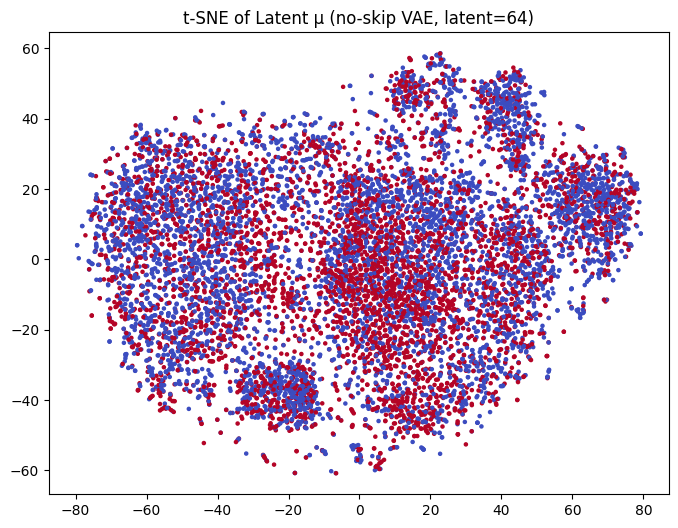

In [16]:
MAX = 10000
idx = np.random.choice(len(train_X), size=min(MAX, len(train_X)), replace=False)
X_tsne = train_X[idx]
Y_tsne = train_Y[idx]
any_abn = (Y_tsne.sum(axis=1) > 0).astype(int)

tsne = TSNE(n_components=2, perplexity=30, random_state=SEED)
Z = tsne.fit_transform(X_tsne)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=any_abn, cmap="coolwarm", s=5)
plt.title("t-SNE of Latent μ (no-skip VAE, latent=64)")
plt.show()
